In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [3]:
def opening(img, kernel, e_it=1, d_it=1):   
    erosion = cv2.erode(img, kernel, iterations = e_it)
    dilation = cv2.dilate(erosion, kernel, iterations = d_it)
    
    return dilation

In [4]:
def find_limits(img, lb, ub):
    w, h = img.shape
    im_arr = np.reshape(img, (w*h))
    
    im_arr = np.sort(im_arr)
    
    i_a = int(round(w*h * lb, 0))
    i_b = int(round(w*h * ub, 0))
    
    a = im_arr[i_a-1]
    b = im_arr[i_b-1]
    
    t = find_t(im_arr, i_a, i_b)
    
    return a, b, t

def find_t(arr, ia, ib):
    a, b = arr[ia], arr[ib]
    
    interval = arr[ia:ib+1]
    mean_i = sum(interval) / len(interval)
    
    t = (2*mean_i*(b - a)) / (255*(a+b))
    print(t)
    
    return t

def nl_grayscale(img, lb, ub):
    new_a = 0
    new_b = 255
    a, b, t = find_limits(img, lb, ub)
    w, h = img.shape
    

    im_out = img.copy()
    
    i = img<a
    im_out[i] = new_a
    
    i = img > b
    im_out[i] = new_b
    
    
    for i in range(w):
        for j in range(h):
            if img[i, j] < a and not img[i, j] > b:
                new_a + ((new_a - new_b) / (a**t - b**t)) * (img[i, j]**t - a**t)
                
                
    #im_out[not img<b] = new_b
    #im_out[img<a and not img<b] = new_a
    
    return im_out

In [5]:
# The purpose of pre-processing is to reduce the variance in pixel intensities, while preserving the crack region.
# Ideally, this should make segmentation perform better, since the background becomes more uniform.

# Random images
# label_p = "C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Positive\\{0:05d}.jpg".format(np.random.randint(1,10000))
# label_n = "C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Negative\\{0:05d}.jpg".format(np.random.randint(1,20000))

# Specific images
label_p = "C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Positive\\{0:05d}.jpg".format(148)
label_n = "C:\\Users\\Rasmus\\Desktop\\Deep Learning\\concrete_data\\Negative\\{0:05d}.jpg".format(5550)

pos = cv2.imread(label_p)
neg = cv2.imread(label_n)

cv2.imshow("Positive", pos)
cv2.imshow("Negative", neg)
cv2.waitKey(0)
cv2.destroyAllWindows()

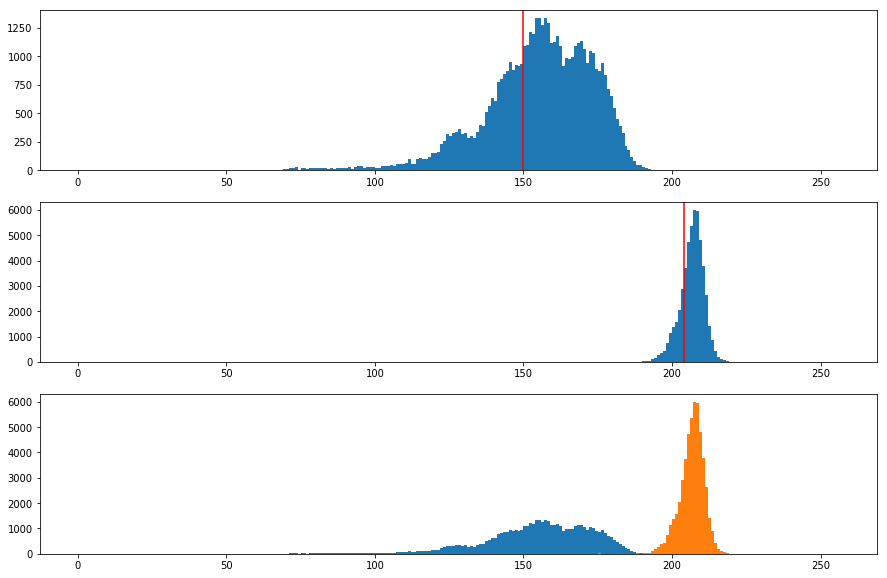

In [7]:
# Grayscale Conversion
g_pos = cv2.cvtColor(pos, cv2.COLOR_BGR2GRAY)
g_neg = cv2.cvtColor(neg, cv2.COLOR_BGR2GRAY)

# Median Filtering 
m_pos = cv2.medianBlur(g_pos, 5)
m_neg = cv2.medianBlur(g_neg, 5)

# Threshold
val_pos, bin_pos = cv2.threshold(m_pos, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
val_neg, bin_neg = cv2.threshold(m_neg, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Plot grayscale histograms
plt.figure(figsize=(15,10))
plt.subplot(3, 1, 1)
plt.hist(m_pos.ravel(),256,[0,256])
plt.axvline(val_pos, color='r')
plt.subplot(3, 1, 2)
plt.hist(m_neg.ravel(),256,[0,256])
plt.axvline(val_neg, color='r')
plt.subplot(3, 1, 3)
plt.hist(m_pos.ravel(),256,[0,256])
plt.hist(m_neg.ravel(),256,[0,256])
plt.show()

In [8]:
# Pre-processing using opening (erosion -> erosion -> dilation)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))

o_pos = opening(m_pos, kernel, 3, 1)
o_neg = opening(m_neg, kernel, 3, 1)

val_pos1, bin_pos1 = cv2.threshold(o_pos, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
val_neg1, bin_neg1 = cv2.threshold(g_neg, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

cv2.imshow("Grayscale", g_pos)
cv2.imshow("New Grayscale", o_pos)
cv2.imshow("Neg Grayscale", g_neg)
cv2.imshow("Neg New Grayscale", o_neg)
cv2.waitKey(0)
cv2.destroyAllWindows()

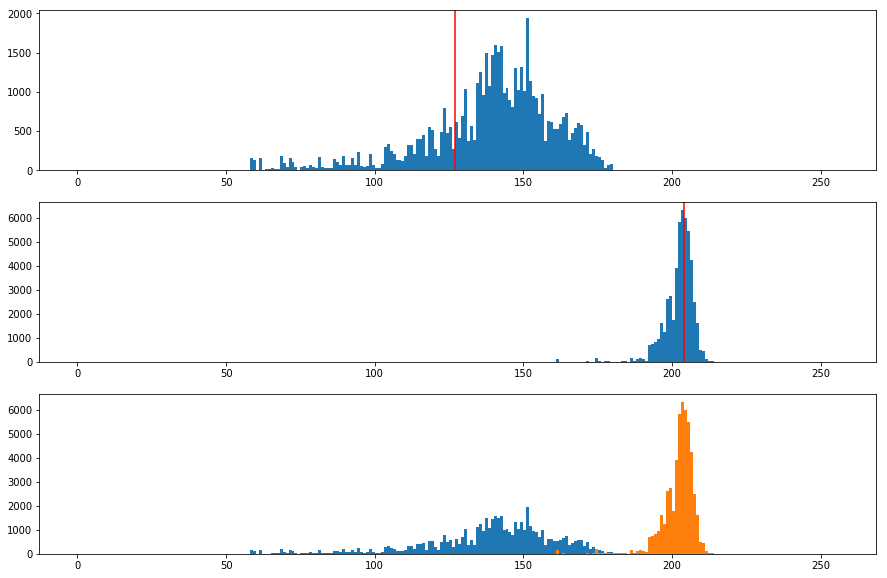

In [9]:
plt.figure(figsize=(15,10))
plt.subplot(3, 1, 1)
plt.hist(o_pos.ravel(),256,[0,256])
plt.axvline(val_pos1, color='r')
plt.subplot(3, 1, 2)
plt.hist(o_neg.ravel(),256,[0,256])
plt.axvline(val_neg1, color='r')
plt.subplot(3, 1, 3)
plt.hist(o_pos.ravel(),256,[0,256])
plt.hist(o_neg.ravel(),256,[0,256])
plt.show()

In [14]:
val_pos, th_pos = cv2.threshold(m_pos, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
val_neg, th_neg = cv2.threshold(m_neg, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
open_pos = cv2.morphologyEx(th_pos, cv2.MORPH_OPEN, kernel)
open_neg = cv2.morphologyEx(th_neg, cv2.MORPH_OPEN, kernel)

ub_pos = round(np.count_nonzero(open_pos)/(227*227), 4)
ub_neg = round(np.count_nonzero(open_neg)/(227*227), 4)

nl_pos = nl_grayscale(m_pos, 0.02, ub_pos)
nl_neg = nl_grayscale(m_neg, 0.02, ub_neg)

val_pos2, th_pos = cv2.threshold(nl_pos, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
val_neg2, th_neg = cv2.threshold(nl_neg, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

a = nl_pos[nl_pos != 0]
a = a[a != 255]

val_pos4, th_pos = cv2.threshold(a, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

cv2.imshow("Grayscale", m_pos)
cv2.imshow("New Grayscale", nl_pos)
cv2.imshow("Neg Grayscale", m_neg)
cv2.imshow("Neg New Grayscale", nl_neg)

cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars


10.803813696447687
0.0878236223558335


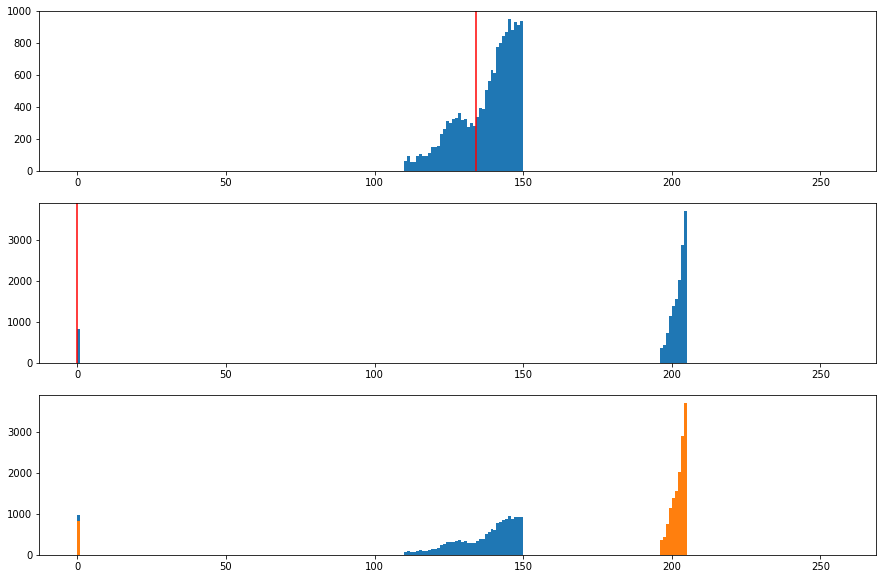

In [224]:
plt.figure(figsize=(15,10))
plt.subplot(3, 1, 1)
plt.hist(a.ravel(),256,[0,256])
plt.axvline(val_pos4, color='r')
#plt.axvline(val_pos4, color='y')
plt.subplot(3, 1, 2)
plt.hist(nl_neg[nl_neg != 255].ravel(),256,[0,256])
plt.axvline(val_neg2, color='r')
plt.subplot(3, 1, 3)
plt.hist(nl_pos[nl_pos != 255].ravel(),256,[0,256])
plt.hist(nl_neg[nl_neg != 255].ravel(),256,[0,256])
plt.show()

[110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149]


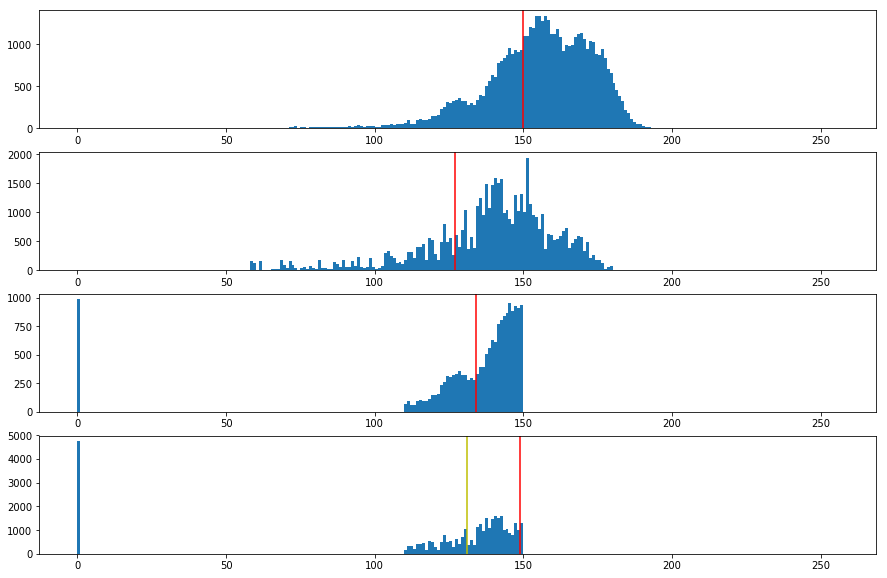

In [11]:
hmm = opening(nl_pos, kernel, 3, 1)
val_pos3, th_pos = cv2.threshold(hmm, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

b = hmm[hmm != 255]
b = b[b != 0]
print(np.unique(b))
val_pos5, th_pos = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


plt.figure(figsize=(15,10))
plt.subplot(4, 1, 1)
plt.hist(m_pos.ravel(),256,[0,256])
plt.axvline(val_pos, color='r')
plt.subplot(4, 1, 2)
plt.hist(o_pos.ravel(),256,[0,256])
plt.axvline(val_pos1, color='r')
plt.subplot(4, 1, 3)
plt.hist(nl_pos[nl_pos != 255].ravel(),256,[0,256])
plt.axvline(val_pos4, color='r')
plt.subplot(4, 1, 4)
plt.hist(hmm[hmm != 255].ravel(),256,[0,256])
plt.axvline(val_pos3, color='r')
plt.axvline(val_pos5, color='y')
plt.show()

In [12]:
ret, nlbin_pos = cv2.threshold(nl_pos, val_pos5, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

cv2.imshow("Non Pre Non Non-linear", bin_pos)
cv2.imshow("Non Non-linear", bin_pos1)
cv2.imshow("Non-linear", nlbin_pos)

cv2.waitKey(0)
cv2.destroyAllWindows()

150.0
142.0


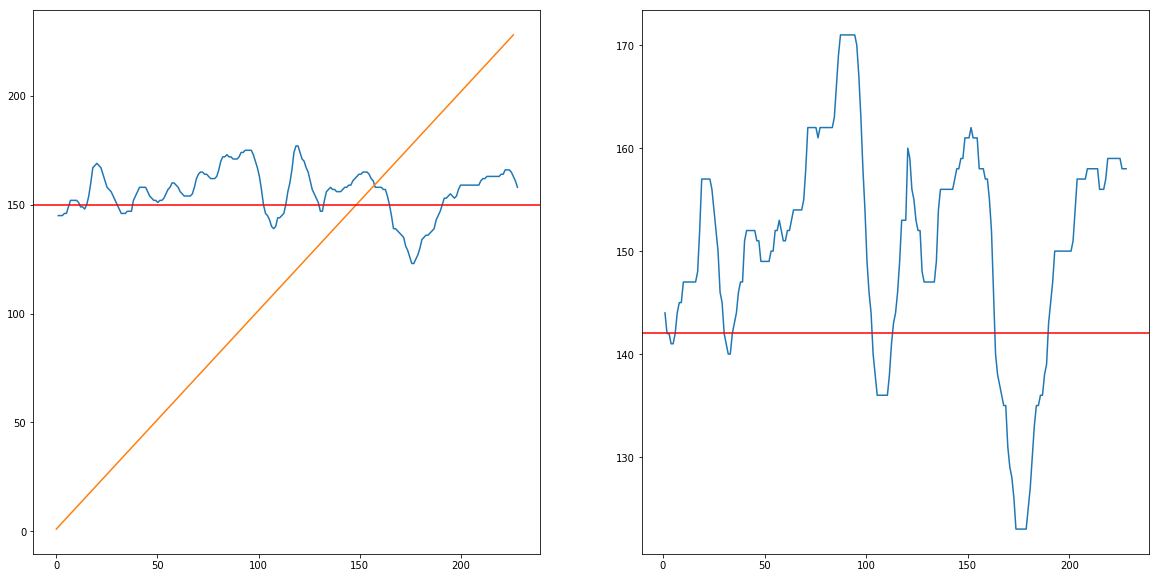

In [157]:
# Variance comparison: 

w, h = g_pos.shape

x = np.linspace(1, w+1, w)
old_y = g_pos[155]
new_y = o_pos[155]

print(val_pos)
print(val_pos1)

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(x, old_y, x)
plt.axhline(val_pos, color='r')
plt.subplot(1,2,2)
plt.plot(x, new_y)
plt.axhline(val_pos1, color='r')
plt.show()

In [158]:
cv2.imshow("Grayscale", g_pos)
cv2.imshow("No pre-processing", bin_pos)
cv2.imshow("Pre-processing", bin_pos1)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [159]:
out_p = opening(bin_pos, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), 1, 0)
out_n = opening(bin_neg, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), 1, 0)


cv2.imshow("Positive", pos)
cv2.imshow("Negative", neg)

cv2.imshow("NPos", out_p)
cv2.imshow("Neg", out_n)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [160]:
pp = round(np.count_nonzero(out_p)/(227*227), 4)
pn = round(np.count_nonzero(out_n)/(227*227), 4)

nl_pos = nl_grayscale(o_pos, 0.02, pp)
nl_neg = nl_grayscale(o_neg, 0.02, pn)

cv2.imshow("Positive", pos)
cv2.imshow("Negative", neg)

cv2.imshow("Pos", nl_pos)
cv2.imshow("Neg", nl_neg)
cv2.waitKey(0)
cv2.destroyAllWindows()

0.1861553730192037
0.078308934320529


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars


In [161]:
def find_limits(img, lb, ub):
    w, h = img.shape
    im_arr = np.reshape(img, (w*h))
    
    im_arr = np.sort(im_arr)
    
    i_a = int(round(w*h * lb, 0))
    i_b = int(round(w*h * ub, 0))
    
    a = im_arr[i_a-1]
    b = im_arr[i_b-1]
    
    t = find_t(im_arr, i_a, i_b)
    
    return a, b, t

def find_t(arr, ia, ib):
    a, b = arr[ia], arr[ib]
    
    interval = arr[ia:ib+1]
    mean_i = interval.mean()
    
    t = (2*mean_i*(b - a)) / (255*(a+b))
    return t

def nl_grayscale(img, lb, ub):
    '''
    Non-Linear Greyscale Transformation
    
    Need's fixing: Upper Bound (ub) values .. if above 1.0 or below 0.02 it will mess up
    '''
    new_a = 0
    new_b = 255
    a, b, t = find_limits(img, lb, ub)
    w, h = img.shape
    

    im_out = img.copy()
    
    i = img<a
    im_out[i] = new_a
    
    i = img > b
    im_out[i] = new_b
    
    for i in range(w):
        for j in range(h):
            if img[i, j] < a and not img[i, j] > b:
                new_a + ((new_a - new_b) / (a**t - b**t)) * (img[i, j]**t - a**t)
                
    
    return im_out